In [1]:
## from https://github.com/yunjey/pytorch-tutorial

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import torch.utils.data as utils

In [2]:
# input_size = 12       # The image size = 28 x 28 = 784
# hidden_size = 500      # The number of nodes at the hidden layer
# num_classes = 2       # The number of output classes. In this case, from 0 to 9
# num_epochs = 5         # The number of times entire dataset is trained
# batch_size = 100       # The size of input data took for one iteration
# learning_rate = 0.001  # The speed of convergence


In [3]:
# Import Dataset
qcd_raw = pd.read_csv('../HiggsReconstruction/EventPlotting/qcd_outputDataForLearning.csv')
hh_raw = pd.read_csv('../HiggsReconstruction/EventPlotting/dihiggs_outputDataForLearning.csv')

qcd_raw.head()
print(len(qcd_raw), "rows of qcd data")
hh_raw.head()
print(len(hh_raw), "rows of dihiggs data")

# Make higgs and qcd sets from raw data
# hh_all = hh_raw[['h1_mass', 'h2_mass', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'jet1_pz', 'jet2_pz', 'jet3_pz', 'jet4_pz', 'jet1_energy', 'jet2_energy', 'jet3_energy', 'jet4_energy']]
# qcd = qcd_raw[['h1_mass', 'h2_mass', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'jet1_pz', 'jet2_pz', 'jet3_pz', 'jet4_pz', 'jet1_energy', 'jet2_energy', 'jet3_energy', 'jet4_energy']]

#same as ruhi
hh_all = hh_raw[['hh_mass', 'h1_mass', 'h2_mass', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'deltaPhi(h1, h2)', 'deltaPhi(h1 jets)', 'deltaPhi(h2 jets)']]
qcd = qcd_raw[['hh_mass', 'h1_mass', 'h2_mass', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'deltaPhi(h1, h2)', 'deltaPhi(h1 jets)', 'deltaPhi(h2 jets)']]

# hh_all = hh_raw[['deltaR(h1 jets)', 'deltaR(h2 jets)']]
# qcd = qcd_raw[['deltaR(h1 jets)', 'deltaR(h2 jets)']]
n_factors = np.shape(hh_all)[1]
print(n_factors)

1703 rows of qcd data
4605 rows of dihiggs data
8


In [4]:
hh_all = np.array(hh_all)
qcd = np.array(qcd)

# add labels to di-higgs
hh_all=hh_all[:,:n_factors]
# # print(hh[0:3])
hh_labels= np.zeros((len(hh_all),1))
hh_labels = hh_labels+1
#a = hh[:len(hh)]
# print(a.shape)
hh_all[:,0] = np.random.rand(np.shape(hh_all)[0])
hh_all = np.append(hh_all, hh_labels, axis=1)
hh_all = np.append(hh_all, 1-hh_labels, axis=1)## hh qcd labels 


# print(hh.shape)
# print(hh[0:3])

# add labels to qcd
qcd=qcd[:,:n_factors]
# print(hh[0:3])
qcd_labels= np.zeros((len(qcd),1))
#a = hh[:len(hh)]
# print(a.shape)
# qcd hh labels 
qcd[:, 0] = -1 * np.random.rand(np.shape(qcd)[0])
qcd = np.append(qcd, qcd_labels, axis=1) 
qcd = np.append(qcd, 1-qcd_labels, axis=1)# qcd qcd labels


# use this for dummy variables
# hh_all[:,0] = np.random.rand(np.shape(hh_all)[0])
# hh_all[:,1] = np.random.rand(np.shape(hh_all)[0])
# qcd[:, 0] = -1 * np.random.rand(np.shape(qcd)[0])
# qcd[:, 1] = -1 * np.random.rand(np.shape(qcd)[0])
# qcd[:, 0] = np.random.rand(np.shape(qcd)[0])
# qcd[:, 1] = np.random.rand(np.shape(qcd)[0])
# qcd[:, 0] = hh_all[:len(qcd),0] -1#-.5
# qcd[:, 1] = hh_all[:len(qcd),1] -1#-.5


# select a quarter of hh events so that the set is half and half
# we shuffle the list first to take a random 1/4. this means we have a different dataset every time
# np.random.seed(0)
# np.random.shuffle(hh_all) 
hh = hh_all[0:len(qcd)]
# print(hh[:4])
# print(qcd[:4])

all_data = np.append(hh,qcd, axis=0) 
all_data[:n_factors,:]

np.random.seed(0)
# for i in range (4): # shuffle 4 times
#     np.random.shuffle(all_data) 
print(all_data[:4])
all_labels = all_data[:,n_factors:]
# for testing model resilience
# for i in range(2):
#     np.random.shuffle(all_labels)
all_data = all_data[:,:n_factors]
# print(all_data[:4])
print(all_labels[:4])
# print(test_data)
# print(len(all_data))
# print(all_labels)

input_size = n_factors       # The image size = 28 x 28 = 784
hidden_size = 500      # The number of nodes at the hidden layer
num_classes = all_labels.shape[1]       # The number of output classes. In this case, from 0 to 9
num_epochs = 5         # The number of times entire dataset is trained
batch_size = 100       # The size of input data took for one iteration
learning_rate = 0.001  # The speed of convergence

[[ 1.59318947e-02  1.48291836e+02  1.58296646e+02  2.39941158e+00
   3.04517197e+00 -1.39974523e+00  2.26137894e+00 -2.73688633e+00
   1.00000000e+00  0.00000000e+00]
 [ 6.76571469e-01  9.65536398e+01  5.85546013e+01  1.34373550e+00
   1.11838980e+00 -2.62879683e+00  1.20060802e+00  1.10447589e+00
   1.00000000e+00  0.00000000e+00]
 [ 2.12799951e-01  1.10271880e+02  1.30164227e+02  6.97377344e-01
   1.15238492e+00 -1.70520791e+00 -6.44060135e-01  1.15179259e+00
   1.00000000e+00  0.00000000e+00]
 [ 1.85365460e-01  1.79640526e+02  1.66136193e+02  2.05337635e+00
   2.09055659e+00 -2.44151538e+00 -1.87211138e+00  1.42004728e+00
   1.00000000e+00  0.00000000e+00]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [5]:
# scale the data by dividing it by the max value of each
for i in range(np.shape(all_data)[1]):
    all_data[:,i] = np.true_divide(all_data[:,i], np.max(all_data[:,i]))
print(all_data[:4])

[[ 0.01593693  0.20528419  0.26390849  0.43658628  0.60794872 -0.44564699
   0.71985814 -0.87118638]
 [ 0.67678545  0.13366168  0.09762087  0.24450015  0.22327923 -0.83694901
   0.38218603  0.35156898]
 [ 0.21286725  0.15265219  0.21700677  0.12689168  0.23006613 -0.54289934
  -0.20502178  0.3666305 ]
 [ 0.18542409  0.24868099  0.2769784   0.37362324  0.41736598 -0.77732286
  -0.59594373  0.45201945]]


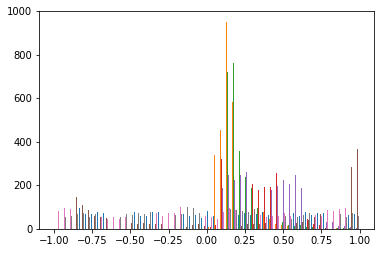

In [6]:
plt.hist(all_data, bins=50)
plt.show()

In [7]:
train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, train_size=0.3, test_size=0.5, random_state=42)

train_data = torch.stack([torch.Tensor(i) for i in train_data])
train_labels = torch.stack([torch.Tensor(i) for i in train_labels])
test_data = torch.stack([torch.Tensor(i) for i in test_data])
test_labels = torch.stack([torch.Tensor(i) for i in test_labels])



train_dataset = utils.TensorDataset(train_data, train_labels)

test_dataset = utils.TensorDataset(test_data, test_labels)

print(train_dataset)

In [8]:

train_loader = utils.DataLoader(train_dataset)

test_loader = utils.DataLoader(test_dataset)
print(train_loader)

In [9]:
print(enumerate(train_loader))
for i, e in enumerate(train_loader):
    print(i, e)
    if(i>4):
        break

0 [tensor([[ 0.7244,  0.4726,  0.5254,  0.5906,  0.6293,  0.6913, -0.9937, -0.9703]]), tensor([[1., 0.]])]
1 [tensor([[-0.6916,  0.1496,  0.2398,  0.1998,  0.3372,  0.9316, -0.3328, -0.5155]]), tensor([[0., 1.]])]
2 [tensor([[ 0.3793,  0.1374,  0.1940,  0.1896,  0.2406, -0.9624, -0.2967,  0.3297]]), tensor([[1., 0.]])]
3 [tensor([[-0.9789,  0.3535,  0.3438,  0.6307,  0.6811, -0.9389, -0.8562, -0.5508]]), tensor([[0., 1.]])]
4 [tensor([[-0.9326,  0.3576,  0.2657,  0.5276,  0.4398, -0.9080, -0.9216,  0.1880]]), tensor([[0., 1.]])]
5 [tensor([[ 0.6748,  0.3276,  0.3842,  0.5811,  0.7800, -0.9923, -0.9717,  0.3890]]), tensor([[1., 0.]])]


In [10]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()                    # Inherited from the parent class nn.Module
        self.fc1 = nn.Linear(input_size, hidden_size)  # 1st Full-Connected Layer: 784 (input data) -> 500 (hidden node)
#         self.relu = nn.Softmax(dim=None)                          # Non-Linear ReLU Layer: max(0,x)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes) # 2nd Full-Connected Layer: 500 (hidden node) -> 10 (output class)
    
    def forward(self, x):                              # Forward pass: stacking each layer together
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [11]:
net = Net(input_size, hidden_size, num_classes)


In [12]:
# net.cuda()    # You can comment out this line to disable GPU

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [14]:
for epoch in range(num_epochs):
    for i, (data, labels) in enumerate(train_loader):   # Load a batch of images with its (index, data, class)
        data = Variable(data)       # Convert torch tensor to Variable: change image from a vector of size 784 to a matrix of 28 x 28
        labels = Variable(labels)
        
        optimizer.zero_grad()                             # Intialize the hidden weight to all zeros
        outputs = net(data)                             # Forward pass: compute the output class given a image
        labels = labels.long()
        loss = criterion(outputs, torch.max(labels, 1)[1])                 # Compute the loss: difference between the output class and the pre-given label
        loss.backward()                                   # Backward pass: compute the weight
        optimizer.step()                                  # Optimizer: update the weights of hidden nodes
        
        if (i+1) % 100 == 0:                              # Logging
#             print("SMH")
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data.item()))
print(len(train_dataset))

Epoch [1/5], Step [100/10], Loss: 0.5263
Epoch [1/5], Step [200/10], Loss: 0.0138
Epoch [1/5], Step [300/10], Loss: 0.0158
Epoch [1/5], Step [400/10], Loss: 0.0004
Epoch [1/5], Step [500/10], Loss: 0.0012
Epoch [1/5], Step [600/10], Loss: 0.0001
Epoch [1/5], Step [700/10], Loss: 0.0001
Epoch [1/5], Step [800/10], Loss: 0.0003
Epoch [1/5], Step [900/10], Loss: 0.0026
Epoch [1/5], Step [1000/10], Loss: 0.0000
Epoch [2/5], Step [100/10], Loss: 0.1847
Epoch [2/5], Step [200/10], Loss: 0.0000
Epoch [2/5], Step [300/10], Loss: 0.0000
Epoch [2/5], Step [400/10], Loss: 0.0000
Epoch [2/5], Step [500/10], Loss: 0.0000
Epoch [2/5], Step [600/10], Loss: 0.0000
Epoch [2/5], Step [700/10], Loss: 0.0000
Epoch [2/5], Step [800/10], Loss: 0.0000
Epoch [2/5], Step [900/10], Loss: 0.0001
Epoch [2/5], Step [1000/10], Loss: 0.0000
Epoch [3/5], Step [100/10], Loss: 0.0305
Epoch [3/5], Step [200/10], Loss: 0.0000
Epoch [3/5], Step [300/10], Loss: 0.0000
Epoch [3/5], Step [400/10], Loss: 0.0000
Epoch [3/5], S

In [15]:
correct = 0
total = 0
for data, labels in test_loader:
    data = Variable(data)
    outputs = net(data)
    _, predicted = torch.max(outputs.data, 1)  # Choose the best class from the output: The class with the best score
    total += labels.size(0)                    # Increment the total count
    labels = labels.long()
    correct += (predicted == torch.max(labels, 1)[1]).sum()     # Increment the correct count
    
print('Accuracy of the network on the 10K test images: %d %%' % (100 * correct / total))
print("correct:", correct.item())
print("total:", total)      

Accuracy of the network on the 10K test images: 98 %
correct: 1669
total: 1703
